In [1]:
import heeps
from heeps.util.img_processing import get_radial_profile
from heeps.util.coord import disk_coord, mas2rms
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def add_curve(xy, label, rel_flux=1):
    x = xy[0]
    y = xy[1] * rel_flux
    if 'IMG' in label:
        plt.plot(x , y, 'k', label=label)
    else:
        plt.plot(x , y, label=label)
    plt.legend()
    plt.xlabel('Angular separation [mas]')
    plt.ylabel('Relative flux')
    plt.grid(True); plt.grid(which='minor', linestyle=':')
    plt.yscale('log')
    plt.xlim(0, 200)
    plt.ylim(1e-6, 1);

def rel_flux(case, band='L', mode='RAVC', nframes=200, nframes_avg=100, xbin=1, verbose=True):
    conf = dict(
        dir_output = 'output_files/resolved_stars/%s'%case,
        band = band,
        mode = mode,
        add_phase = False,
        f_phase = 'wavefront/cfull/cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285.fits',
        nframes = 1,
        nframes_avg = nframes_avg,
    )
    if 'RAVC' in conf['mode']:
        conf.update(ls_dRext=0.0477, ls_dRint=0.04, ls_dRspi=0.0249)
    elif 'CVC' in conf['mode']:
        conf.update(ls_dRext=0.0209, ls_dRint=0.09, ls_dRspi=0.0245)
    elif 'CLC' in conf['mode']:
        conf.update(ls_dRext=0.1095, ls_dRint=0.0491, ls_dRspi=0.0317)
    conf = heeps.config.read_config(**conf)
    conf = heeps.config.update_config(**conf)
    wf = heeps.pupil.pupil(**conf)
    # image radius
    rim = conf['ndet'] // 2 
    (xo,yo) = (rim, rim)
    xval = np.arange(rim)*conf['pscale']
    # IMG reference
    conf['mode'] = 'ELT'
    psf_elt = heeps.wavefront.propagate(wf, **conf)[0]
    yelt = get_radial_profile(psf_elt, (xo,yo), xbin)[:-1]
    peak_elt = np.max(yelt)
    yelt /= peak_elt
    os.chdir(conf['dir_output'])
    fits.writeto('psf_%s_%s_%s_no_error.fits'%(band, 'ELT', case), np.float32(psf_elt), overwrite=True)
    fits.writeto('rel_flux_%s_%s_%s_no_error.fits'%(band, 'ELT', case), np.array([xval, yelt]), overwrite=True)
    # HCI; no error
    conf['mode'] = mode
    if 'alphaCen' in case:
        conf['fp_offsets'] = mas2rms(disk_coord(4.26, nr=3), 36.905)
        conf['mag'] = -1.6
    elif 'pi1Gru' in case:
        conf['fp_offsets'] = mas2rms(disk_coord(9.18, nr=4), 36.905)
        conf['mag'] = -0.6
    else:
        conf['fp_offsets'] = None
    psf = heeps.wavefront.propagate(wf, **conf)[0]
    yval = get_radial_profile(psf, (xo,yo), xbin)[:-1]
    yval /= peak_elt
    fits.writeto('psf_%s_%s_%s_no_error.fits'%(band, mode, case), np.float32(psf), overwrite=True)
    fits.writeto('rel_flux_%s_%s_%s_no_error.fits'%(band, mode, case), np.array([xval, yval]), overwrite=True)
    # HCI; scao only
    conf['add_phase'] = True
    conf['nframes'] = nframes
    psf_ON = heeps.wavefront.propagate(wf, savefits=True, verbose=verbose, **conf)
    psf_ON_avg = np.mean(psf_ON, axis=0)
    yval = get_radial_profile(psf_ON_avg, (xo,yo), xbin)[:-1]
    yval /= peak_elt
    fits.writeto('psf_%s_%s_%s_scao_only.fits'%(band, mode, case), np.float32(psf_ON_avg), overwrite=True)
    fits.writeto('rel_flux_%s_%s_%s_scao_only.fits'%(band, mode, case), np.array([xval, yval]), overwrite=True)
    # off-axis PSF of a point-like source 
    conf['fp_offsets'] = None
    heeps.wavefront.propagate(wf, avg=True, onaxis=False, savefits=True, **conf);
    # adi contrast curve
    conf['add_bckg'] = False
    heeps.contrast.adi_one(savefits=True, verbose=True, **conf);
#    if case in ['alphaCen','pi1Gru']:
#        conf['add_bckg'] = True
#        heeps.contrast.adi_one(savefits=True, **conf);

In [3]:
rel_flux('pointSource')

   2022-07-26 21:10:15, e2e simulation using 56 cores
   2022-07-26 21:10:17, completed in 1.87 seconds
   2022-07-26 21:10:18, e2e simulation using 56 cores
   2022-07-26 21:10:22, completed in 4.01 seconds
On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=200 (nframes=200, nstep=1)
Create on-axis PSF cube
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.04, 0.0249], ls_misalign=None
   2022-07-26 21:10:25, e2e simulation using 56 cores
   2022-07-26 21:11:03, completed in 37.64 seconds

   2022-07-26 21:11:07, e2e simulation using 56 cores
   2022-07-26 21:11:22, completed in 15.02 seconds
Apply ADI technique: add_bckg=False
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=RAVC, band=L
   ncube=200, ndet=403
   pscale=5.47 mas, dit=0.3 s
   load vortex off-axis transmission from 'oat_L_RAVC.fits'
――――――――――――――――――――――――――――――

In [4]:
rel_flux('alphaCen')

   2022-07-26 21:13:43, e2e simulation using 56 cores
   2022-07-26 21:13:46, completed in 2.63 seconds
   2022-07-26 21:13:48, e2e simulation using 56 cores
   2022-07-26 21:14:33, completed in 45.68 seconds
On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=200 (nframes=200, nstep=1)
Create on-axis PSF cube
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.04, 0.0249], ls_misalign=None
   2022-07-26 21:14:37, e2e simulation using 56 cores
   2022-07-26 21:24:01, completed in 563.85 seconds

   2022-07-26 21:24:05, e2e simulation using 56 cores
   2022-07-26 21:24:21, completed in 15.95 seconds
Apply ADI technique: add_bckg=False
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   mode=RAVC, band=L
   ncube=200, ndet=403
   pscale=5.47 mas, dit=0.3 s
   load vortex off-axis transmission from 'oat_L_RAVC.fits'
――――――――――――――――――――――――――――

In [ ]:
rel_flux('pi1Gru')

   2022-07-26 21:26:37, e2e simulation using 56 cores
   2022-07-26 21:26:40, completed in 2.56 seconds
   2022-07-26 21:26:41, e2e simulation using 56 cores
   2022-07-26 21:28:09, completed in 87.96 seconds
On-axis PSF:
‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20220512_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=200 (nframes=200, nstep=1)
Create on-axis PSF cube
   apply ring apodizer: ravc_t=0.7909, ravc_r=0.519, apo_misalign=None
   apply Lyot stop: circ_ext/int=[False, True], ls_dRext/int/spi=[0.0477, 0.04, 0.0249], ls_misalign=None
   2022-07-26 21:28:13, e2e simulation using 56 cores


# Figures: relative flux 

In [3]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/output_files/resolved_stars')))

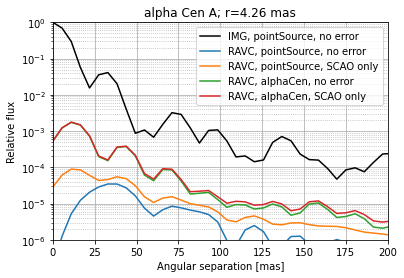

In [4]:
case = 'pointSource'
add_curve(fits.getdata('%s/rel_flux_L_ELT_%s_no_error.fits'%(case, case)), 'IMG, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_RAVC_%s_no_error.fits'%(case, case)), 'RAVC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_RAVC_%s_scao_only.fits'%(case, case)), 'RAVC, %s, SCAO only'%case)
case = 'alphaCen'
add_curve(fits.getdata('%s/rel_flux_L_RAVC_%s_no_error.fits'%(case, case)), 'RAVC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_RAVC_%s_scao_only.fits'%(case, case)), 'RAVC, %s, SCAO only'%case)
plt.title('alpha Cen A; r=4.26 mas')
plt.savefig('rel_flux_%s.png'%case, dpi=300, transparent=True)

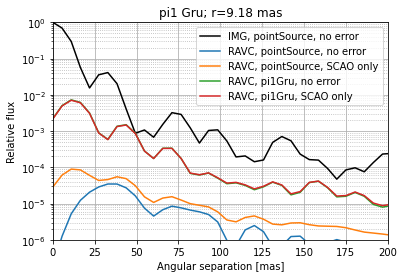

In [5]:
case = 'pointSource'
add_curve(fits.getdata('%s/rel_flux_L_ELT_%s_no_error.fits'%(case, case)), 'IMG, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_RAVC_%s_no_error.fits'%(case, case)), 'RAVC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_RAVC_%s_scao_only.fits'%(case, case)), 'RAVC, %s, SCAO only'%case)
case = 'pi1Gru'
add_curve(fits.getdata('%s/rel_flux_L_RAVC_%s_no_error.fits'%(case, case)), 'RAVC, %s, no error'%case)
add_curve(fits.getdata('%s/rel_flux_L_RAVC_%s_scao_only.fits'%(case, case)), 'RAVC, %s, SCAO only'%case)
plt.title('pi1 Gru; r=9.18 mas')
plt.savefig('rel_flux_%s.png'%case, dpi=300, transparent=True)

# Figures: ADI contrast

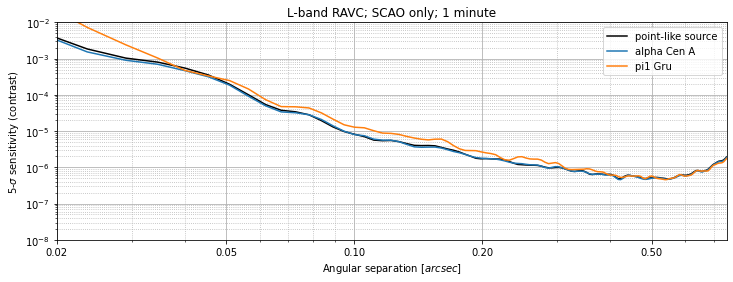

In [6]:
xlabel = 'Angular separation $[arcsec]$'
ylabel_adi = '5-$\sigma$ sensitivity (contrast)'

SO_L_PS = fits.getdata('%s/cc_adi_bckg0_L_RAVC.fits'%'pointSource')
SO_L_AC = fits.getdata('%s/cc_adi_bckg0_L_RAVC.fits'%'alphaCen')
SO_L_PG = fits.getdata('%s/cc_adi_bckg0_L_RAVC.fits'%'pi1Gru')
plt.figure(figsize=(12,4))
plt.plot(SO_L_PS[0], SO_L_PS[1], 'k', label='point-like source')
plt.plot(SO_L_AC[0], SO_L_AC[1], label='alpha Cen A')
plt.plot(SO_L_PG[0], SO_L_PG[1], label='pi1 Gru')
plt.loglog()
plt.grid(True), plt.grid(which='minor', linestyle=':')
plt.legend()
plt.xlabel(xlabel)
plt.ylabel(ylabel_adi)
plt.title('L-band RAVC; SCAO only; 1 minute')
plt.xlim(0.02, 0.75)
plt.ylim(1e-8, 1e-2)
plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
plt.savefig('resolved_stars.png', transparent=True, dpi=300)